# Neural Network from Scratch

In this notebook, we will implement a simple neural network from scratch using NumPy and train it on the Digits dataset. We will cover steps such as initializing weights, forward and backward propagation, and updating weights using gradient descent. Our goal is to classify handwritten digit images.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

In [ ]:
# Load the Digits dataset
digits = load_digits()
X = digits.data
y = digits.target.reshape(-1, 1)  # Change the shape into a two-dimensional array with one column

In [ ]:
# Normalize the feature data
X = X / 16.0  # Digits are between 0 and 16

In [ ]:
# One-hot encode the target variable
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y)

In [ ]:
y_encoded

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

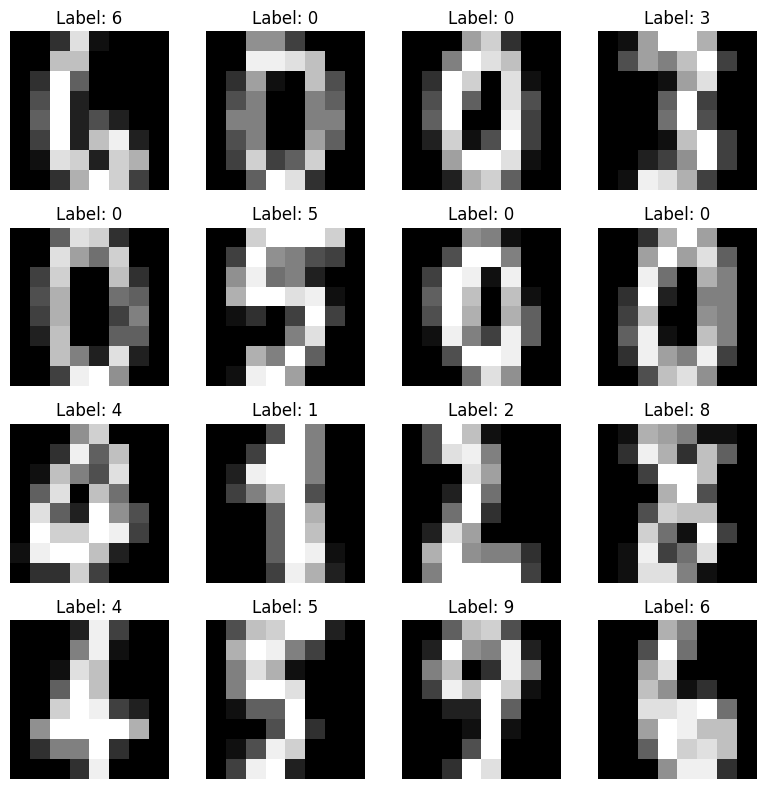

In [ ]:
# Function to plot a grid of digit images with their ground truth labels
def plot_digits(X, y, num_images=16):
    """
    Plot a grid of digit images with their ground truth labels.

    Parameters:
    - X: Feature data (images)
    - y: Labels (ground truth)
    - num_images: Number of images to display (default is 16)
    """
    plt.figure(figsize=(8, 8))
    images_per_row = int(np.sqrt(num_images))
    for i in range(num_images):
        plt.subplot(images_per_row, images_per_row, i + 1)
        plt.imshow(X[i].reshape(8, 8), cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Select a subset of the training data for plotting
num_images_to_plot = 16
X_plot = X_train[:num_images_to_plot]
y_plot = np.argmax(y_train[:num_images_to_plot], axis=1)

# Plot the digits with their labels
plot_digits(X_plot, y_plot, num_images=num_images_to_plot)

In [ ]:
def initialize_parameters(input_size, hidden_size, output_size):
    """
    Initialize the weights and biases for the neural network.

    Parameters:
    - input_size: Number of input features
    - hidden_size: Number of neurons in the hidden layer
    - output_size: Number of output classes

    Returns:
    - parameters: Dictionary containing initialized weights and biases
    """
    np.random.seed(42)  # For reproducibility
    parameters = {
        'W1': np.random.randn(input_size, hidden_size) * 0.01,
        'b1': np.zeros((1, hidden_size)),
        'W2': np.random.randn(hidden_size, output_size) * 0.01,
        'b2': np.zeros((1, output_size))
    }
    return parameters

# Initialize parameters
input_size = X_train.shape[1]  # 64 features for each digit image (8x8)
hidden_size = 32  # You can adjust this
output_size = y_train.shape[1]  # 10 output classes (digits 0-9)
parameters = initialize_parameters(input_size, hidden_size, output_size)

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def softmax(z):
    exp_z = np.exp(z)
    softmax_probs = exp_z / np.sum(exp_z, axis=1, keepdims=True)
    return softmax_probs

def compute_loss(y_true, y_pred):
    m = y_true.shape[0]
    loss = -np.sum(y_true * np.log(y_pred + 1e-9)) / m   # Average cross-entropy loss
    return loss

In [ ]:
def forward_propagation(X, parameters):
    """
    Perform forward propagation through the network.

    Parameters:
    - X: Input data
    - parameters: Dictionary containing weights and biases

    Returns:
    - A2: Output of the output layer (predictions)
    - cache: Dictionary containing intermediate values for use in backpropagation
    """
    W1, b1, W2, b2 = parameters['W1'], parameters['b1'], parameters['W2'], parameters['b2']

    # Input to hidden layer
    Z1 = np.dot(X, W1) + b1
    A1 = sigmoid(Z1)

    # Hidden to output layer
    Z2 = np.dot(A1, W2) + b2
    A2 = softmax(Z2)

    cache = {'Z1': Z1, 'A1': A1, 'Z2': Z2, 'A2': A2}
    return A2, cache

# Perform a forward pass with the training data
A2, cache = forward_propagation(X_train, parameters)
print(f"Initial Loss: {compute_loss(y_train, A2):.4f}")

Initial Loss: 2.3027


In [ ]:
def backward_propagation(X, y, parameters, cache):
    """
    Perform backward propagation through the network.

    Parameters:
    - X: Input data
    - y: True labels
    - parameters: Dictionary containing weights and biases
    - cache: Dictionary containing intermediate values from forward propagation

    Returns:
    - grads: Dictionary containing gradients of weights and biases
    """
    m = X.shape[0]
    W1, W2 = parameters['W1'], parameters['W2']
    A1, A2 = cache['A1'], cache['A2']

    # Output layer gradients
    dZ2 = A2 - y
    dW2 = np.dot(A1.T, dZ2) / m
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m

    # Hidden layer gradients
    dA1 = np.dot(dZ2, W2.T)
    dZ1 = dA1 * (A1 * (1 - A1))  # Sigmoid derivative
    dW1 = np.dot(X.T, dZ1) / m
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m

    grads = {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}
    return grads

In [ ]:
def update_parameters(parameters, grads, learning_rate):
    """
    Update the weights and biases using gradient descent.

    Parameters:
    - parameters: Dictionary containing weights and biases
    - grads: Dictionary containing gradients of weights and biases
    - learning_rate: Learning rate for gradient descent

    Returns:
    - parameters: Updated weights and biases
    """
    parameters['W1'] -= learning_rate * grads['dW1']
    parameters['b1'] -= learning_rate * grads['db1']
    parameters['W2'] -= learning_rate * grads['dW2']
    parameters['b2'] -= learning_rate * grads['db2']
    return parameters

In [ ]:
def train(X, y, input_size, hidden_size, output_size, learning_rate, num_iterations):
    """
    Train the neural network.

    Parameters:
    - X: Input data
    - y: True labels
    - input_size: Number of input features
    - hidden_size: Number of neurons in the hidden layer
    - output_size: Number of output classes
    - learning_rate: Learning rate for gradient descent
    - num_iterations: Number of iterations to train

    Returns:
    - parameters: Trained weights and biases
    """
    parameters = initialize_parameters(input_size, hidden_size, output_size)

    for i in range(num_iterations):
        # Forward propagation
        A2, cache = forward_propagation(X, parameters)

        # Compute loss
        loss = compute_loss(y, A2)

        # Backward propagation
        grads = backward_propagation(X, y, parameters, cache)

        # Update parameters
        parameters = update_parameters(parameters, grads, learning_rate)

        if i % 100 == 0 or i == num_iterations - 1:
            print(f"Iteration {i}: Loss = {loss:.4f}")

    return parameters

# Train the model
parameters = train(X_train, y_train, input_size, hidden_size, output_size, learning_rate=0.1, num_iterations=1000)

Iteration 0: Loss = 2.3027
Iteration 100: Loss = 2.3009
Iteration 200: Loss = 2.2988
Iteration 300: Loss = 2.2932
Iteration 400: Loss = 2.2769
Iteration 500: Loss = 2.2308
Iteration 600: Loss = 2.1175
Iteration 700: Loss = 1.9124
Iteration 800: Loss = 1.6607
Iteration 900: Loss = 1.4269
Iteration 999: Loss = 1.2338


In [ ]:
def predict(X, parameters):
    """
    Predict the labels for given input data.

    Parameters:
    - X: Input data
    - parameters: Trained weights and biases

    Returns:
    - predictions: Predicted labels
    """
    A2, _ = forward_propagation(X, parameters)
    predictions = np.argmax(A2, axis=1)
    return predictions

# Make predictions on the test set
y_pred_train = predict(X_train, parameters)
y_pred_test = predict(X_test, parameters)

# Convert one-hot encoded labels to single labels
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Calculate and print accuracy
train_accuracy = accuracy_score(y_train_labels, y_pred_train)
test_accuracy = accuracy_score(y_test_labels, y_pred_test)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 71.82%
Testing Accuracy: 73.33%


## Exercises

* Experiment with the neural network architecture by changing the number of neurons in the hidden layer.
* Replace the sigmoid activation function in the hidden layer with the ReLU activation function.
* Explore the effect of different learning rates on the training process and model performance.
* Visualize how the network's predictions evolve over time.